Установка зависимостей

In [ ]:
# Установка дополнительных зависимостей
!pip install fiona
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import cv2
import fiona
import json
import torch
import warnings

import pandas as pd 
import numpy as np
import albumentations as A
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks
from PIL import Image
from IPython.display import clear_output
from pprint import pprint

warnings.filterwarnings("ignore")

Скачиваем и подготавливаем датасет для работы

In [ ]:
![ ! -s "./eye-dataset.zip" ] && curl -L -o eye-dataset.zip "https://drive.google.com/uc?export=download&id=1NKJ9g7NtUDn8aaNEJmG8Ybx_raLAiB7T"
![ ! -s "./train" ] && unzip eye-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 7797k  100 7797k    0     0  1994k      0  0:00:03  0:00:03 --:--:--  176M
Archive:  eye-dataset.zip
  inflating: README.md               
  inflating: __MACOSX/._README.md    
   creating: test/
  inflating: __MACOSX/._test         
  inflating: test/.DS_Store          
  inflating: __MACOSX/test/._.DS_Store  
  inflating: test/15.png             
  inflating: __MACOSX/test/._15.png  
  inflating: test/17.png             
  inflating: __MACOSX/test/._17.png  
  inflating: test/16.png             
  inflating: __MACOSX/test/._16.png  
  inflating: test/18.png             
  inflating: __MACOSX/test/._18.png  
  inflating: test/19.png             
  inflating: __MACOSX/test/._19.png  
   creating: train/
  inflating: __MACOSX/._train        
  inflat

Класс для загрузки датасета

In [ ]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*[0-9].png")

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]

        # Получаем соответствующий файл разметки
        mask_path = image_path.replace(".png", "_mask.png")

        image = self.read_image(image_path)
        mask = self.read_image(mask_path)

        sample = {'image': image,
                  'mask': mask}

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace(".png", "_mask.png"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        reports.append(f"Найдено {cnt_images_without_masks} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    def __len__(self) -> int:
        return len(self.indices)


In [ ]:
# Задаем преобразование изображений
size = 1024
train_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True),
              ]
eval_list = [A.LongestMaxSize(size, interpolation=cv2.INTER_CUBIC),
              A.PadIfNeeded(size, size),
              ToTensorV2(transpose_mask=True)]

transforms = {'train': A.Compose(train_list), 'test': A.Compose(eval_list)}


In [ ]:
# Инициализируем датасет
dataset = EyeDataset("/content/train")

In [ ]:
# Проверим состояние загруженного датасета
for msg in dataset.make_report():
  print(msg)

Найдено 15 изображений
Для всех изображений есть файл разметки


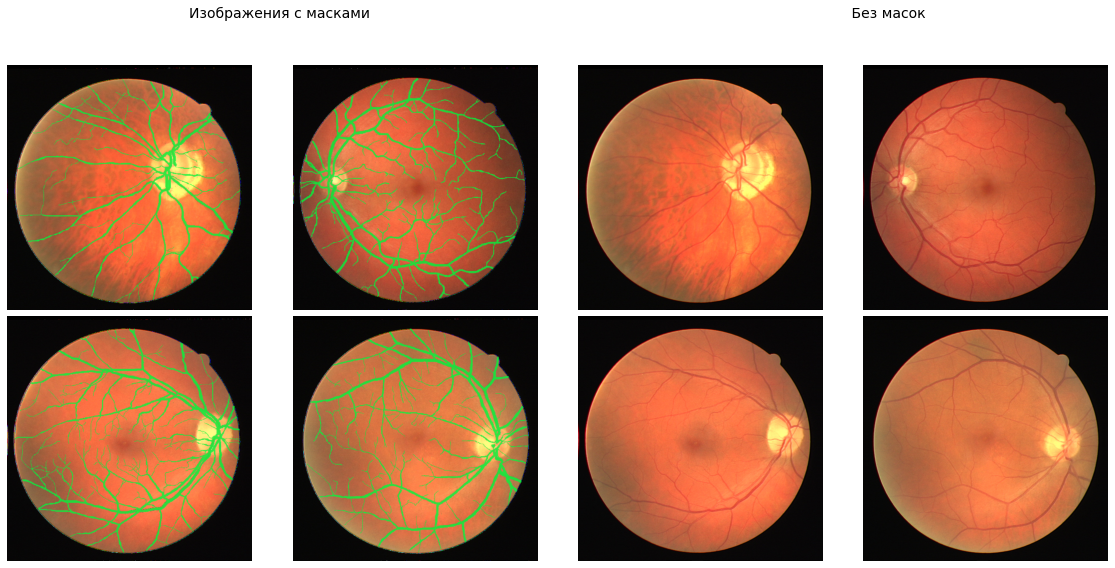

In [ ]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)


for i, sample in zip(range(4), dataset):
    transformed = transforms['test'](**sample)
    image, mask = transformed["image"], transformed["mask"]

    image_with_mask = draw_segmentation_masks((image.cpu() * 255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
from os import listdir

print("Обучающей выборки " ,len(listdir("/content/train")) // 2)
print("Тестовой выборки " ,len(listdir("/content/test")))

Обучающей выборки  15
Тестовой выборки  6


In [ ]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.25)


In [ ]:
print(f"Разбиение на train/test : {len(train_indices)}/{len(test_indices)}")

Разбиение на train/test : 11/4


In [ ]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transform=transforms['train'])
valid_dataset = DatasetPart(dataset, test_indices, transform=transforms['test'])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 1,
                                   num_workers=4,
                                   shuffle=True, drop_last=True)

In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

class UnetTrainer:
    """
    Класс, реализующий обучение модели
    """

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer,
                 criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                 device: str, metric_functions: List[Tuple[str, Callable]] = [],
                 epoch_number: int = 0,
                 lr_scheduler: Optional[Any] = None):
        self.model = model
        self.optimizer = optimizer  
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler

        self.device = device

        self.metric_functions = metric_functions

        self.epoch_number = epoch_number

    @torch.no_grad()
    def evaluate_batch(self, val_iterator: Iterator, eval_on_n_batches: int) -> Optional[Dict[str, float]]:     
        predictions = []
        targets = []

        losses = []
        for real_batch_number in range(eval_on_n_batches):
            try:
                batch = next(val_iterator)

                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break
            ys_pred = self.model.eval()(xs)
            loss = self.criterion(ys_pred, ys_true)

            losses.append(loss.item())

            predictions.append(ys_pred.cuda())
            targets.append(ys_true.cuda())

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}

        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        return metrics

    @torch.no_grad()
    def evaluate(self, val_loader, eval_on_n_batches: int = 1) -> Dict[str, float]:
        """
        Вычисление метрик для эпохи
        """
        metrics_sum = defaultdict(float)
        num_batches = 0

        val_iterator = iter(val_loader)

        while True:
            batch_metrics = self.evaluate_batch(val_iterator, eval_on_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit_batch(self, train_iterator: Iterator, update_every_n_batches: int) -> Optional[Dict[str, float]]:
        """
        Тренировка модели на одном батче
        """

        self.optimizer.zero_grad()

        predictions = []
        targets = []

        losses = []
        for real_batch_number in range(update_every_n_batches):
            try:
                batch = next(train_iterator)
 
                xs = batch['image'].to(self.device)
                ys_true = batch['mask'].to(self.device)
            except StopIteration:
                if real_batch_number == 0:
                    return None
                else:
                    break

            ys_pred = self.model.train()(xs)

            loss = self.criterion(ys_pred, ys_true)

            (loss / update_every_n_batches).backward()
          
            losses.append(loss.item())
            
            predictions.append(ys_pred.cpu())
            targets.append(ys_true.cpu())
            

       
        self.optimizer.step()

        predictions = torch.cat(predictions, dim=0)
        targets = torch.cat(targets, dim=0)

        metrics = {'loss': np.mean(losses)}
    
        for metric_name, metric_fn in self.metric_functions:
            metrics[metric_name] = metric_fn(predictions, targets).item()
        
        return metrics

    def fit_epoch(self, train_loader, update_every_n_batches: int = 1) -> Dict[str, float]:
        """
        Одна эпоха тренировки модели
        """

        metrics_sum = defaultdict(float)
        num_batches = 0

        train_iterator = iter(train_loader)

        while True:
            batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)

            if batch_metrics is None:
                break

            for metric_name in batch_metrics:
                metrics_sum[metric_name] += batch_metrics[metric_name]

            num_batches += 1

        metrics = {}

        for metric_name in metrics_sum:
            metrics[metric_name] = metrics_sum[metric_name] / num_batches

        return metrics

    def fit(self, train_loader, num_epochs: int,
            val_loader = None, update_every_n_batches: int = 1,
            ) -> Dict[str, np.ndarray]:
        """
        Метод, тренирующий модель и вычисляющий метрики для каждой эпохи
        """

        summary = defaultdict(list)

        def save_metrics(metrics: Dict[str, float], postfix: str = '') -> None:
          # Сохранение метрик в summary
            nonlocal summary, self

            for metric in metrics:
                metric_name, metric_value = f'{metric}{postfix}', metrics[metric]

                summary[metric_name].append(metric_value)

        for _ in tqdm(range(num_epochs - self.epoch_number), initial=self.epoch_number, total=num_epochs):
            self.epoch_number += 1

            train_metrics = self.fit_epoch(train_loader, update_every_n_batches)
            
            with torch.no_grad():
                save_metrics(train_metrics, postfix='_train')

                if val_loader is not None:
                    test_metrics = self.evaluate(val_loader)
                    save_metrics(test_metrics, postfix='_test')

            if self.lr_scheduler is not None:
                self.lr_scheduler.step()

        summary = {metric: np.array(summary[metric]) for metric in summary}

        return summary


In [ ]:
# F1-мера
class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)

# Метрика полноты
class Recall:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: List[Dict[str, torch.Tensor]],
                 targets: List[Dict[str, torch.Tensor]]) -> torch.Tensor:
        numerator = torch.sum(predictions * targets)
        denominator = torch.sum(targets)

        return numerator / (denominator + self.epsilon)

# Метрика точности
class Accuracy:
    def __init__(self, epsilon=1e-8, b=1):
        self.epsilon = epsilon
        self.a = b*b

    def __call__(self, predictions: list, targets: list) -> torch.Tensor:
        numerator = torch.sum(targets)
        denominator = torch.sum(predictions * targets)

        return numerator / (denominator + self.epsilon)

def make_metrics():
    soft_dice = SoftDice()
    recall = Recall()
    _accuracy = Accuracy()

    def exp_dice(pred, target):
        return soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    def accuracy(pred, target):
        return _accuracy(torch.exp(pred[:, 1:]), target[:, 1:])

    def exp_recall(pred, target):
        return recall(torch.exp(pred[:, 1:]), target[:, 1:])

    return [('exp_dice', exp_dice),
            ('accuracy', accuracy),
            ('recall', exp_recall),
            ]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Подргружаем модель и задаём функцию потерь
model = smp.Unet('resnet50', activation='logsoftmax', classes=2)

model.cuda()

def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(torch.exp(pred[:, 1:]), target[:, 1:])

    return exp_dice

criterion = make_criterion()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

In [ ]:
# Обучаем модель
metric_functions = make_metrics()
trainer = UnetTrainer(model, optimizer, criterion, 'cuda', metric_functions=metric_functions)
summary = trainer.fit(train_loader, 10, val_loader=valid_loader)

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


In [ ]:
summary

{'loss_train': array([0.81356682, 0.75572388, 0.71876414, 0.68637263, 0.65541512,
        0.62468413, 0.59290415, 0.5627624 , 0.53228671, 0.50269765]),
 'exp_dice_train': array([0.18643317, 0.24427612, 0.28123585, 0.31362739, 0.3445849 ,
        0.37531588, 0.40709584, 0.43723757, 0.46771329, 0.49730232]),
 'accuracy_train': array([1.43983298, 1.17387747, 1.12024162, 1.10081058, 1.09638112,
        1.09493498, 1.09670269, 1.10187002, 1.10415943, 1.10472846]),
 'recall_train': array([0.70449021, 0.85227983, 0.89298487, 0.9087677 , 0.91255061,
        0.91380683, 0.91257161, 0.90828344, 0.90642754, 0.90587535]),
 'loss_test': array([0.82328649, 0.78265943, 0.7405934 , 0.68144977, 0.63186239,
        0.59008902, 0.55586691, 0.5262883 , 0.50288351, 0.47464809]),
 'exp_dice_test': array([0.17671353, 0.21734058, 0.25940659, 0.31855023, 0.36813761,
        0.40991097, 0.44413309, 0.4737117 , 0.49711648, 0.52535191]),
 'accuracy_test': array([1.72412425, 1.70806342, 1.39970121, 1.25413644, 1.1

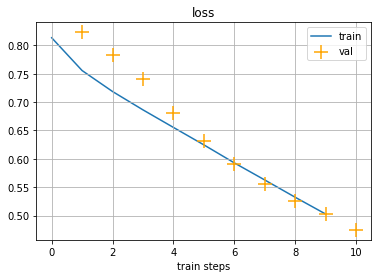

In [ ]:
# Функция потерь
plot_history(summary['loss_train'], summary['loss_test'])

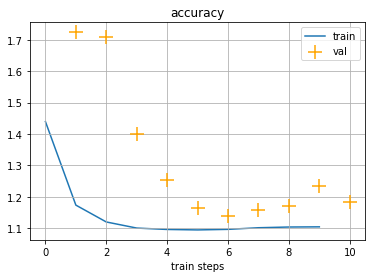

In [ ]:
# Точность
plot_history(summary['accuracy_train'], summary['accuracy_test'], "accuracy")

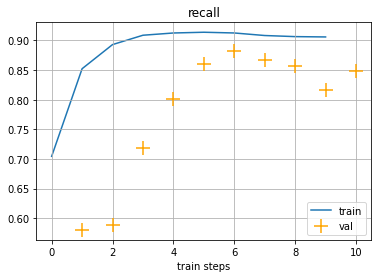

In [ ]:
# Полнота
plot_history(summary['recall_train'], summary['recall_test'], "recall")

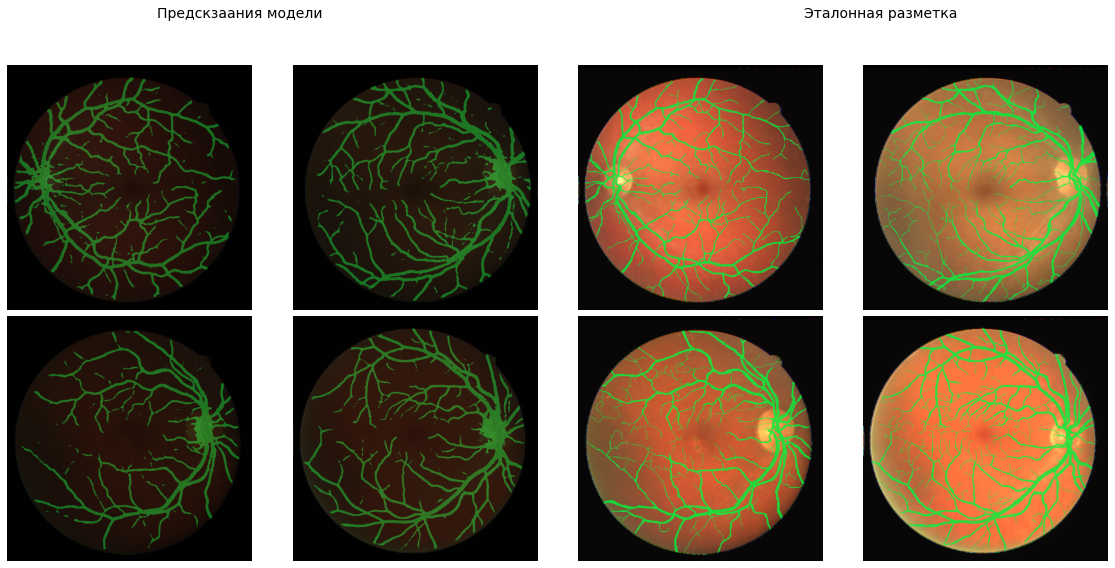

In [ ]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_maks = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_maks.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)
